## Look at fermi and swift data

In [1]:
%matplotlib notebook
import ipympl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from astropy.io import fits
from glob import glob
import lightkurve as lk

from astropy.wcs import WCS

/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipympl/__init__.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/Users/ryanr/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/ryanr/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/ryanr/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/User

In [17]:
c11_1 = '/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo203830112-c111_lpd-targ.fits.gz'
c11_2 = '/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo203830112-c112_lpd-targ.fits.gz'

tpf1 = lk.KeplerTargetPixelFile(c11_1)
tpf2 = lk.KeplerTargetPixelFile(c11_2)

explosion = 57689.52720367 # t0 from fitting in in the main 20383112 notebook

tpf1_mask = np.zeros(tpf1.flux[0].shape)
tpf1_mask[11:14,3:10] = 1

tpf2_mask = np.zeros(tpf2.flux[0].shape)
tpf2_mask[9:11,3:10] = 1

lc_1 = np.nansum(tpf1.flux*tpf1_mask,axis=(1,2))
lc_2 = np.nansum(tpf2.flux*tpf2_mask,axis=(1,2))

## Fermi data

Check to see if the nearby events have a time that overlaps.

Fermi time is taken in seconds from MJD 51910, so there is an easy way to compare times. Now to understand how the data is stored.

### Fermi data files:
Each event has its own dimension in the array. 
The event info is stored in a length 23 boolean array.

0 - Energy (MeV)

1 - RA (deg)

2 - DEC (deg)

9 - Time (s in MET)

10 - Event ID

In [91]:
Fermi_files = glob('./fermi lat/Long/3deg/*PH*')

fermi_time = []
fermi_energy = []
fermi_coord = []

for file in Fermi_files:
    hdu = fits.open(file)
    dat = hdu[1]
    fermi = hdu[1]
    fermi_dat = fermi.data
    
    for i in range(len(fermi_dat)):
        fermi_energy.append(fermi_dat[i][0])
        fermi_time.append(fermi_dat[i][9])
        fermi_coord.append([fermi_dat[i][1],fermi_dat[i][2]])
        
fermi_energy = np.array(fermi_energy)  
fermi_time = np.array(fermi_time)
fermi_coord = np.array(fermi_coord)

fermi_mjd = fermi_time/(60**2*24)+51910

In [8]:
fermi_coord.shape

(52265, 2)

In [103]:
def Fermi_coord_error(Envergy):
    if Energy > 10e9:
        error = 

<IPython.core.display.Javascript object>


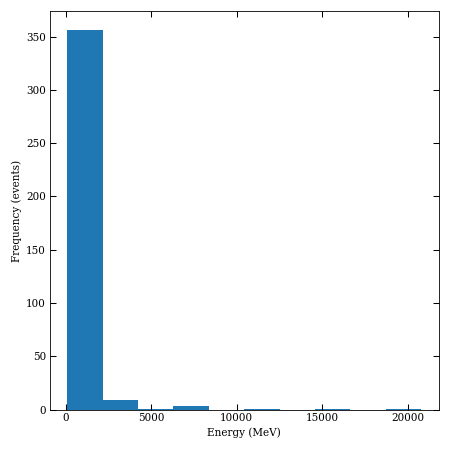

In [81]:
plt.figure()
plt.hist(fermi_energy)
plt.ylabel('Frequency (events)')
plt.xlabel('Energy (MeV)')
plt.tight_layout();

<IPython.core.display.Javascript object>


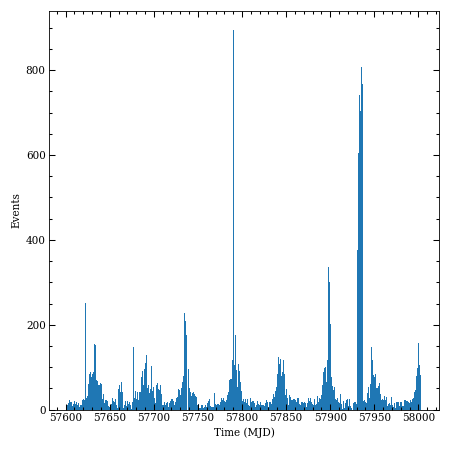

In [16]:
plt.figure()
plt.hist(fermi_mjd,bins=1000)
#plt.axvline(30/(60*24),color='red',label='30 min from start point')
plt.ylabel('Events')
plt.xlabel('Time (MJD)')
#plt.xlim(0,0.1)
#plt.ylim(0,20)
plt.tight_layout()
plt.minorticks_on()
#plt.savefig('Fermi_events.png')

<IPython.core.display.Javascript object>


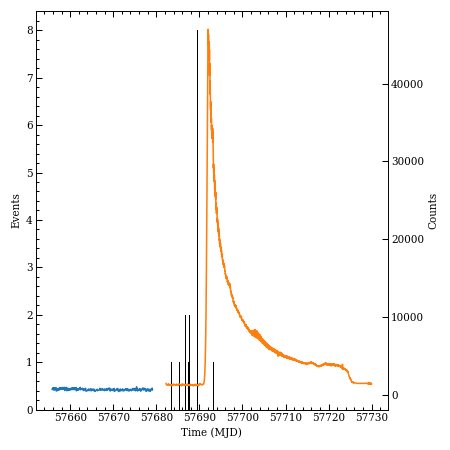

In [82]:
fig, ax = plt.subplots()
plt.hist(fermi_mjd,bins=2000,color='black')
plt.ylabel('Events')
plt.xlabel('Time (MJD)')
#plt.xlim(0,3)
#plt.ylim(0,20)
plt.tight_layout()
plt.minorticks_on()

ax2 = ax.twinx()

plt.plot(tpf1.astropy_time.mjd,lc_1)
plt.plot(tpf2.astropy_time.mjd,lc_2)
plt.ylabel('Counts')
#plt.ylim(22,13.6)
plt.tight_layout()

#plt.savefig('Fermi_events.png')

There is a very strong oscillation in the number of events. Let's now bin the data into 30 minute intervals to match K2 cadence. With the binned data we can then look into frequencies.

Assume that the K2 time is in the middle of the exposure.

In [32]:
(tpf2.astropy_time.mjd[0] - tpf1.astropy_time.mjd[-1])/(tpf2.astropy_time.mjd[1] - tpf2.astropy_time.mjd[0])

156.0008779436759

In [92]:
kep_exp = tpf2.astropy_time.mjd[1] - tpf2.astropy_time.mjd[0] #30/(60*24) #1765.5s 

f_min = np.min(fermi_mjd)
f_max = np.max(fermi_mjd)

f_start = int((tpf2.astropy_time.mjd[0] - f_min)/kep_exp)
f_end = int((f_max - tpf2.astropy_time.mjd[0])/kep_exp)

bin_start = tpf2.astropy_time.mjd[0] - f_start*kep_exp

t = bin_start
fermi_binned = []
fermi_bin_mjd = []
for i in range(f_start+f_end):
    temp = np.where(np.isclose(fermi_mjd, t, atol = (kep_exp/2)))[0]
    fermi_binned.append(len(temp))
    fermi_bin_mjd.append(t)
    t += kep_exp
fermi_binned = np.array(fermi_binned)
fermi_bin_mjd = np.array(fermi_bin_mjd)

<IPython.core.display.Javascript object>


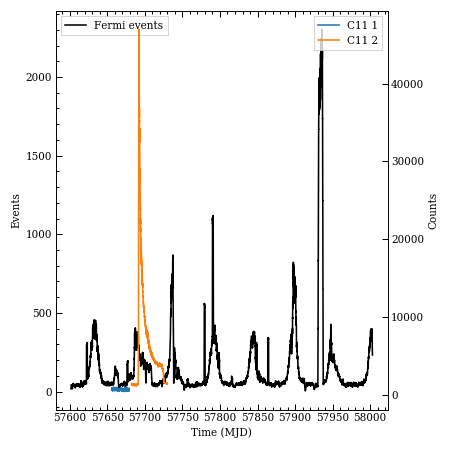

In [93]:
fig, ax = plt.subplots()
plt.plot(fermi_bin_mjd,fermi_binned,'k',label= 'Fermi events')
plt.ylabel('Events')
plt.xlabel('Time (MJD)')
#plt.xlim(57650,57750)
#plt.ylim(0,20)
plt.tight_layout()
plt.minorticks_on()

ax.legend(loc=2)

ax2 = ax.twinx()

plt.plot(tpf1.astropy_time.mjd,lc_1, label = 'C11 1')
plt.plot(tpf2.astropy_time.mjd,lc_2, label = 'C11 2')
plt.ylabel('Counts')

ax2.legend(loc=1)
#plt.axvline(explosion,color='red')
#plt.ylim(22,13.6)
plt.tight_layout()

There appears to be a similar shape between the two, displaced by 5.7 days. Hmmmm

In [70]:
ps = np.abs(np.fft.fft(fermi_binned))**2

time_step = 1#kep_exp
freqs = np.fft.fftfreq(fermi_binned.size, time_step)
idx = np.argsort(freqs)

In [64]:
f, Pxx_den = signal.periodogram(fermi_binned,fs=(1/kep_exp) )

<IPython.core.display.Javascript object>


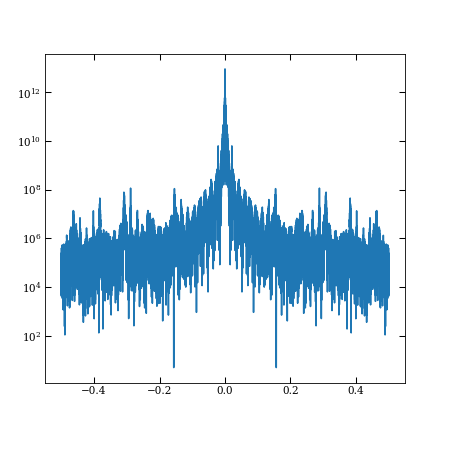

In [71]:
plt.figure()
plt.semilogy(freqs[idx], ps[idx])

<IPython.core.display.Javascript object>


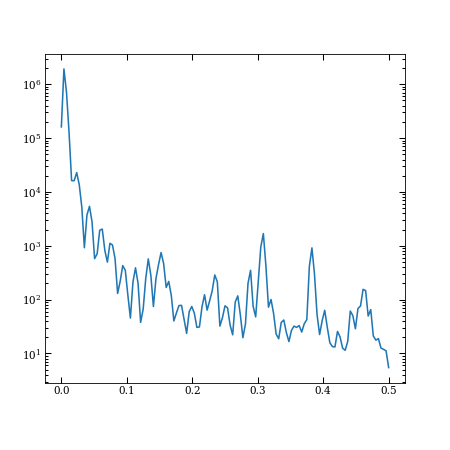

In [76]:

f, Pxx_den = signal.welch(fermi_binned, fs=1)
plt.figure()
plt.semilogy(f, Pxx_den)

In [78]:
686.9-633

53.89999999999998

In [79]:
737.8-686.9

50.89999999999998